In [232]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns
from matplotlib import rcParams

# Import regression and error metrics modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go
import pandas as pd

# Standard scaler for preprocessing
from sklearn.preprocessing import StandardScaler

# Importing time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import *
from sklearn import datasets
import pandas as pd
from pandasql import sqldf
from pycaret.datasets import get_data 
from pycaret.regression import *
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import *
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from sklearn.isotonic import isotonic_regression
from sklearn.linear_model import *
from sklearn.svm import *
from sklearn.neighbors  import *
from sklearn.gaussian_process import *
from sklearn.ensemble import *
from sklearn.experimental import *
from sklearn.neural_network import *
from sklearn.tree import *
from xgboost import *
from sklearn.preprocessing import *
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import std
from geopy.distance import great_circle
import folium
from folium.plugins import HeatMap
from pycaret.anomaly import *
from collections import Counter
from feature_engine.missing_data_imputers import RandomSampleImputer
plt.style.use('bmh')
import seaborn as sns
from matplotlib import rcParams

# Import regression and error metrics modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go
import pandas as pd

# Standard scaler for preprocessing
from sklearn.preprocessing import StandardScaler

# Importing time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit
import os
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 


In [233]:
# creating function for plotting predicted vs actual energy values
def plot_predvstrue_reg(pred, truth, model_name=None):
    """
    Plots the observed energy consumption against the predicted energy consumption
    """
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    ax.scatter(truth, pred) 
    _ = plt.xlabel("Observed energy in MWH")
    _ = plt.ylabel("Predicted energy in MWH")
    _ = plt.title("Observed vs Predicted energy using model {}".format(model_name))
#    _ = plt.xlim(500, 2000)
#    _ = plt.ylim(500, 2000)
    #plotting 45 deg line to see how the prediction differs from the observed values
    x = np.linspace(*ax.get_xlim())
    _ = ax.plot(x, x)

In [234]:
def error_metrics(y_pred, y_truth, model_name = None, test = True):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error), MAPE (mean absolute % error). 
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    model_name: name of the model used for predictions
    test: if validating on test set, True; otherwise False for training set validation
    
    The function will print the RMSE, R2, MAE and MAPE error metrics for the model_name and also store the results along with 
    model_name in the dictionary dict_error so that we can compare all the models at the end.
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

    MAPE = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)
    
    # Appending the error values along with the model_name to the dict
    if test:
        train_test = 'test'
    else:
        train_test = 'train'
    
    #df = pd.DataFrame({'model': model_name, 'RMSE':RMSE, 'R2':R2, 'MAE':MAE, 'MAPE':MAPE}, index=[0])
    name_error = ['model', 'train_test', 'RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [model_name, train_test, RMSE, R2, MAE, MAPE]
    list_error = list(zip(name_error, value_error))
    dict_error={}
    for error in list_error:
        if error[0] in dict_error:
            # append the new number to the existing array at this slot
            dict_error[error[0]].append(error[1])
        else:
            # create a new array in this slot
            dict_error[error[0]] = [error[1]]
    #return(dict_error)

In [235]:
def plot_timeseries(timeseries, title = 'og', opacity = 1):
    """
    Plot plotly time series of any given timeseries ts
    """
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = timeseries.index, y = timeseries.values, name = "observed",
                         line_color = 'lightslategrey', opacity = opacity))

    fig.update_layout(title_text = title,
                  xaxis_rangeslider_visible = True)
    fig.show()

In [236]:
def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    """
    Plot plotly time series of the original (og_ts) and predicted (pred_ts) time series values to check how our model performs.
    model_name: name of the model used for predictions
    og_ts_opacity: opacity of the original time series
    pred_ts_opacity: opacity of the predicted time series
    """
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed test set vs predicted energy MWH values using {}'.format(model_name),
                  xaxis_rangeslider_visible = True)
    fig.show()

In [237]:
def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    """
    Plot plotly time series of the original (og_ts) and predicted (pred_ts) time series values to check how our model performs.
    model_name: name of the model used for predictions
    og_ts_opacity: opacity of the original time series
    pred_ts_opacity: opacity of the predicted time series
    """
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed test set vs predicted energy MWH values using {}'.format(model_name),
                  xaxis_rangeslider_visible = True)
    fig.show()

In [238]:
def train_test(data, test_size = 0.15, scale = False, cols_to_transform=None, include_test_scale=False,z='load_nl'):
    """
    
        Perform train-test split with respect to time series structure
        
        - df: dataframe with variables X_n to train on and the dependent output y which is the column 'SDGE' in this notebook
        - test_size: size of test set
        - scale: if True, then the columns in the -'cols_to_transform'- list will be scaled using StandardScaler
        - include_test_scale: If True, the StandardScaler fits the data on the training as well as the test set; if False, then
          the StandardScaler fits only on the training set.
        
    """
    df = data.copy()
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
    
    # StandardScaler fit on the entire dataset
    if scale and include_test_scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop(z, axis = 1).iloc[:test_index]
    y_train = df[z].iloc[:test_index]
    X_test = df.drop(z, axis = 1).iloc[test_index:]
    y_test = df[z].iloc[test_index:]
    
    # StandardScaler fit only on the training set
    if scale and not include_test_scale:
        scaler = StandardScaler()
        X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
        X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])
    
    return X_train, X_test, y_train, y_test

In [239]:
frame_day=pd.DataFrame()
frame_week=pd.DataFrame()
frame_month=pd.DataFrame()

def data(num):
    def season(month):
        """adding season based on the data on SDGE's site -> https://www.sdge.com/whenmatters#how-it-works; 
        months from June to October are denoted as 'summer' and months from November to May as 'winter'. """
        if month in [6,7,8,9,10]:
            return "summer"
        else:
            return "winter"
    
    df = pd.read_csv(r'archive/'+str(num)+'.csv',usecols=['start','load'],parse_dates=['start'],index_col=['start'])
    df.rename(columns ={'load':'load'+'_'+str(num)},inplace=True)
    return df


In [240]:
data=data(num='nl').resample('H').sum()

In [241]:
data['year']=data.index.year
data['month']=data.index.month
data['day']=data.index.day
data['hour']=data.index.hour


In [242]:
data

load_nl  year  month  day  hour
start                                                     
2015-01-01 00:00:00+00:00  37824.0  2015      1    1     0
2015-01-01 01:00:00+00:00  35827.0  2015      1    1     1
2015-01-01 02:00:00+00:00  33846.0  2015      1    1     2
2015-01-01 03:00:00+00:00  32624.0  2015      1    1     3
2015-01-01 04:00:00+00:00  32504.0  2015      1    1     4
...                            ...   ...    ...  ...   ...
2020-07-31 19:00:00+00:00  51383.0  2020      7   31    19
2020-07-31 20:00:00+00:00  50887.0  2020      7   31    20
2020-07-31 21:00:00+00:00  48864.0  2020      7   31    21
2020-07-31 22:00:00+00:00  46698.0  2020      7   31    22
2020-07-31 23:00:00+00:00  44571.0  2020      7   31    23

[48936 rows x 5 columns]

In [243]:
hour_dict = {'morning': list(np.arange(7,13)),'afternoon': list(np.arange(13,16)), 'evening': list(np.arange(16,22)),
            'night': [22, 23, 0, 1, 2, 3, 4, 5, 6]}

In [244]:
def time_of_day(x):
    if x in hour_dict['morning']:
        return 'morning'
    elif x in hour_dict['afternoon']:
        return 'afternoon'
    elif x in hour_dict['evening']:
        return 'evening'
    else:
        return 'night'

In [245]:
data['time_of_day'] = data['hour'].apply(time_of_day)

In [246]:
# creating categorical columns for linear regression 
#cat_cols1 = ['month', 'day', 'hour','year']
#not including year above to capture the decreasing energy trend over increasing value of years
#for t in cat_cols1:
#    data[t] = data[t].astype('category')



In [247]:
data

load_nl  year  month  day  hour time_of_day
start                                                                 
2015-01-01 00:00:00+00:00  37824.0  2015      1    1     0       night
2015-01-01 01:00:00+00:00  35827.0  2015      1    1     1       night
2015-01-01 02:00:00+00:00  33846.0  2015      1    1     2       night
2015-01-01 03:00:00+00:00  32624.0  2015      1    1     3       night
2015-01-01 04:00:00+00:00  32504.0  2015      1    1     4       night
...                            ...   ...    ...  ...   ...         ...
2020-07-31 19:00:00+00:00  51383.0  2020      7   31    19     evening
2020-07-31 20:00:00+00:00  50887.0  2020      7   31    20     evening
2020-07-31 21:00:00+00:00  48864.0  2020      7   31    21     evening
2020-07-31 22:00:00+00:00  46698.0  2020      7   31    22       night
2020-07-31 23:00:00+00:00  44571.0  2020      7   31    23       night

[48936 rows x 6 columns]

In [248]:
data_=pd.get_dummies(data)

In [249]:
data_

load_nl  year  month  day  hour  \
start                                                        
2015-01-01 00:00:00+00:00  37824.0  2015      1    1     0   
2015-01-01 01:00:00+00:00  35827.0  2015      1    1     1   
2015-01-01 02:00:00+00:00  33846.0  2015      1    1     2   
2015-01-01 03:00:00+00:00  32624.0  2015      1    1     3   
2015-01-01 04:00:00+00:00  32504.0  2015      1    1     4   
...                            ...   ...    ...  ...   ...   
2020-07-31 19:00:00+00:00  51383.0  2020      7   31    19   
2020-07-31 20:00:00+00:00  50887.0  2020      7   31    20   
2020-07-31 21:00:00+00:00  48864.0  2020      7   31    21   
2020-07-31 22:00:00+00:00  46698.0  2020      7   31    22   
2020-07-31 23:00:00+00:00  44571.0  2020      7   31    23   

                           time_of_day_afternoon  time_of_day_evening  \
start                                                                   
2015-01-01 00:00:00+00:00                      0                    0   
2015-01-01 01:00:00+00:00                      0                    0   
2015-01-01 02:00:00+00:00                      0                    0   
2015-01-01 03:00:00+00:00                      0                    0   
2015-01-01 04:00:00+00:00                      0                    0   
...                                          ...                  ...   
2020-07-31 19:00:00+00:00                      0                    1   
2020-07-31 20:00:00+00:00                      0                    1   
2020-07-31 21:00:00+00:00                      0                    1   
2020-07-31 22:00:00+00:00                      0                    0   
2020-07-31 23:00:00+00:00                      0                    0   

                           time_of_day_morning  time_of_day_night  
start                                                              
2015-01-01 00:00:00+00:00                    0                  1  
2015-01-01 01:00:00+00:00                    0                  1  
2015-01-01 02:00:00+00:00                    0                  1  
2015-01-01 03:00:00+00:00                    0                  1  
2015-01-01 04:00:00+00:00                    0                  1  
...                                        ...                ...  
2020-07-31 19:00:00+00:00                    0                  0  
2020-07-31 20:00:00+00:00                    0                  0  
2020-07-31 21:00:00+00:00                    0                  0  
2020-07-31 22:00:00+00:00                    0                  1  
2020-07-31 23:00:00+00:00                    0                  1  

[48936 rows x 9 columns]

In [250]:
# Trying elastic net regression

# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

def trend_model(data, cols_to_transform, l1_space, alpha_space, cols_use = 0, scale = True, test_size = 0.15, 
                include_test_scale=False):
    """
    Tuning, fitting and predicting with an Elastic net regression model.
    data: time series dataframe including X and y variables
    col_use: columns including the y variable to be used from the data
    cols_to_transform: columns to be scaled using StandardScaler if scale = True
    l1_space: potential values to try for the l1_ratio parameter of the elastic net regression
    include_test_scale: If True then the StandardScaler will be fit on the entire dataset instead of just the training set
    
    A note about l1_ratio: The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. 
    For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. 
    For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
    """
    
    # Creating the train test split
    if cols_use != 0:
        df = data[cols_use]
    else:
        df = data
    
    X_train, X_test, y_train, y_test = train_test(df, test_size = test_size, 
                                              scale = scale, cols_to_transform=cols_to_transform, 
                                              include_test_scale=include_test_scale)

    
    # Create the hyperparameter grid
    #l1_space = np.linspace(0, 1, 50)
    param_grid = {'l1_ratio': l1_space, 'alpha': alpha_space}

    # Instantiate the ElasticNet regressor: elastic_net
    elastic_net = ElasticNet()

    # for time-series cross-validation set 5 folds
    tscv = TimeSeriesSplit(n_splits=5)

    # Setup the GridSearchCV object: gm_cv ...trying 5 fold cross validation 
    gm_cv = GridSearchCV(elastic_net, param_grid, cv = tscv)

    # Fit it to the training data
    gm_cv.fit(X_train, y_train)

    # Predict on the test set and compute metrics
    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
    print("Tuned ElasticNet R squared: {}".format(r2))
    print("Tuned ElasticNet RMSE: {}".format(np.sqrt(mse)))
    # fitting the elastic net again using the best model from above

    elastic_net_opt = ElasticNet(l1_ratio = gm_cv.best_params_['l1_ratio']) 
    elastic_net_opt.fit(X_train, y_train)
    
    # Plot the coefficients
    _ = plt.figure(figsize = (15, 7))
    _ = plt.plot(range(len(X_train.columns)), elastic_net_opt.coef_)
    _ = plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
    _ = plt.margins(0.02)
    _ = plt.axhline(0, linewidth = 0.5, color = 'r')
    _ = plt.title('significane of features as per Elastic regularization')
    _ = plt.ylabel('Elastic net coeff')
    _ = plt.xlabel('Features')
    
    # Plotting y_true vs predicted
    _ = plt.figure(figsize = (5,5))
    _ = plot_predvstrue_reg(elastic_net_opt.predict(X_test), y_test, model_name = 'Elastic net optimal linear regression')
    
    # returns the train and test X and y sets and also the optimal model
    return X_train, X_test, y_train, y_test, elastic_net_opt

In [251]:
cols_to_transform = ['year']
l1_space = np.array([0,0.2,0.4,0.6,0.8])
alpha_space = np.logspace(-2, 0, 5)

Tuned ElasticNet l1 ratio: {'alpha': 0.31622776601683794, 'l1_ratio': 0.6}
Tuned ElasticNet R squared: -0.07171437009764259
Tuned ElasticNet RMSE: 8581.752749161478


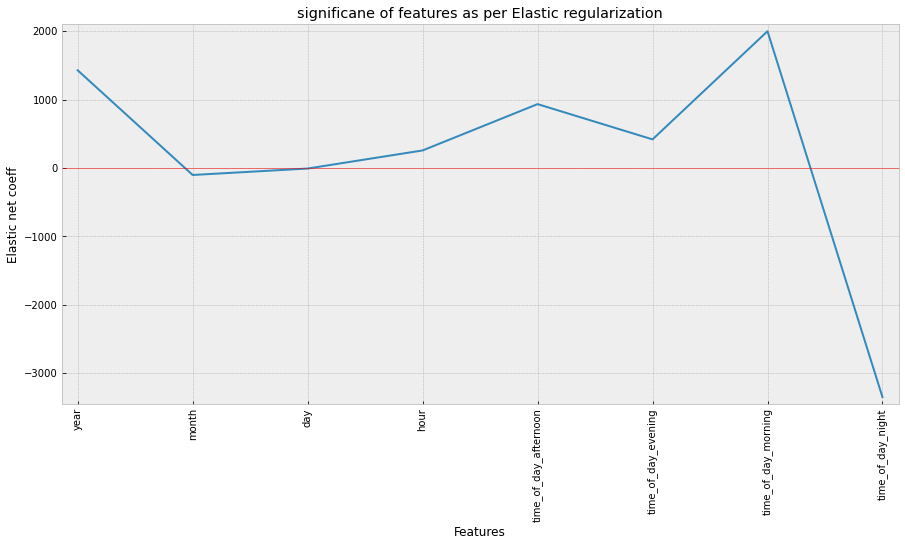

<Figure size 360x360 with 0 Axes>

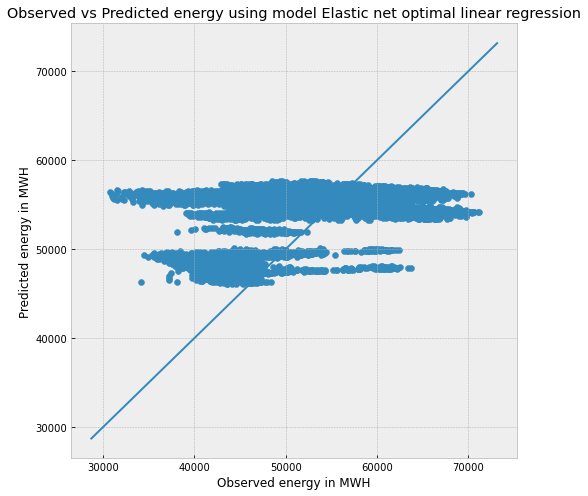

In [158]:
import warnings  
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test, elastic_net_opt = trend_model(data=data_, cols_to_transform=cols_to_transform, 
                                                                l1_space=l1_space, alpha_space=alpha_space,
                                                                scale = True, test_size = 0.15, include_test_scale=False)

In [252]:
from sklearn.ensemble import RandomForestRegressor
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(10, 200, 10, endpoint=True)]
max_features = ['auto', 'sqrt']
max_depth = list(range(1,6))
# Create the random grid
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth':max_depth}
print(random_grid)

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4, 5]}


In [253]:
from sklearn.model_selection import RandomizedSearchCV

# First create the base model to tune
rf = RandomForestRegressor()

# Creating a time series split as discussed in the Introduction
tscv = TimeSeriesSplit(n_splits=5)
# Random search of parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = tscv, verbose=2, random_state = 42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_
#rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.9s finished


{'n_estimators': 73, 'max_features': 'auto', 'max_depth': 5}

In [254]:
rf_random.score(X_train, y_train),rf_random.score(X_test, y_test) 


(0.7022556942832495, 0.4168822285057524)

In [255]:
plot_ts_pred(y_test, rf_random.predict(X_test), model_name='Tuned Random forest with reduced hour space', \
             og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

In [256]:

print('Tuned Random forest errors on training set')
error_metrics(rf_random.predict(X_train), y_train, model_name = 'Tuned Random forest with reduced hour space', test = False)
print('\nTuned Random forest errors on test set')
error_metrics(rf_random.predict(X_test), y_test, model_name = 'Tuned Random forest with reduced hour space', test = True)

Tuned Random forest errors on training set

Error metrics for model Tuned Random forest with reduced hour space
RMSE or Root mean squared error: 5106.43
Variance score: 0.70
Mean Absolute Error: 3954.19
Mean Absolute Percentage Error: 8.00 %

Tuned Random forest errors on test set

Error metrics for model Tuned Random forest with reduced hour space
RMSE or Root mean squared error: 6330.16
Variance score: 0.42
Mean Absolute Error: 4648.02
Mean Absolute Percentage Error: 9.99 %


In [257]:
for i in range(24):
    data_['lag'+str(i+1)] = data_['load_nl'].shift(i+1)
    

In [258]:
data_ = data_.dropna()

In [259]:
data_

load_nl  year  month  day  hour  \
start                                                        
2015-01-02 00:00:00+00:00  33211.0  2015      1    2     0   
2015-01-02 01:00:00+00:00  31504.0  2015      1    2     1   
2015-01-02 02:00:00+00:00  30801.0  2015      1    2     2   
2015-01-02 03:00:00+00:00  31086.0  2015      1    2     3   
2015-01-02 04:00:00+00:00  33018.0  2015      1    2     4   
...                            ...   ...    ...  ...   ...   
2020-07-31 19:00:00+00:00  51383.0  2020      7   31    19   
2020-07-31 20:00:00+00:00  50887.0  2020      7   31    20   
2020-07-31 21:00:00+00:00  48864.0  2020      7   31    21   
2020-07-31 22:00:00+00:00  46698.0  2020      7   31    22   
2020-07-31 23:00:00+00:00  44571.0  2020      7   31    23   

                           time_of_day_afternoon  time_of_day_evening  \
start                                                                   
2015-01-02 00:00:00+00:00                      0                    0   
2015-01-02 01:00:00+00:00                      0                    0   
2015-01-02 02:00:00+00:00                      0                    0   
2015-01-02 03:00:00+00:00                      0                    0   
2015-01-02 04:00:00+00:00                      0                    0   
...                                          ...                  ...   
2020-07-31 19:00:00+00:00                      0                    1   
2020-07-31 20:00:00+00:00                      0                    1   
2020-07-31 21:00:00+00:00                      0                    1   
2020-07-31 22:00:00+00:00                      0                    0   
2020-07-31 23:00:00+00:00                      0                    0   

                           time_of_day_morning  time_of_day_night     lag1  \
start                                                                        
2015-01-02 00:00:00+00:00                    0                  1  35981.0   
2015-01-02 01:00:00+00:00                    0                  1  33211.0   
2015-01-02 02:00:00+00:00                    0                  1  31504.0   
2015-01-02 03:00:00+00:00                    0                  1  30801.0   
2015-01-02 04:00:00+00:00                    0                  1  31086.0   
...                                        ...                ...      ...   
2020-07-31 19:00:00+00:00                    0                  0  51488.0   
2020-07-31 20:00:00+00:00                    0                  0  51383.0   
2020-07-31 21:00:00+00:00                    0                  0  50887.0   
2020-07-31 22:00:00+00:00                    0                  1  48864.0   
2020-07-31 23:00:00+00:00                    0                  1  46698.0   

                              lag2     lag3     lag4     lag5     lag6  \
start                                                                    
2015-01-02 00:00:00+00:00  39295.0  42254.0  43513.0  45459.0  46866.0   
2015-01-02 01:00:00+00:00  35981.0  39295.0  42254.0  43513.0  45459.0   
2015-01-02 02:00:00+00:00  33211.0  35981.0  39295.0  42254.0  43513.0   
2015-01-02 03:00:00+00:00  31504.0  33211.0  35981.0  39295.0  42254.0   
2015-01-02 04:00:00+00:00  30801.0  31504.0  33211.0  35981.0  39295.0   
...                            ...      ...      ...      ...      ...   
2020-07-31 19:00:00+00:00  50338.0  48501.0  46348.0  43000.0  41110.0   
2020-07-31 20:00:00+00:00  51488.0  50338.0  48501.0  46348.0  43000.0   
2020-07-31 21:00:00+00:00  51383.0  51488.0  50338.0  48501.0  46348.0   
2020-07-31 22:00:00+00:00  50887.0  51383.0  51488.0  50338.0  48501.0   
2020-07-31 23:00:00+00:00  48864.0  50887.0  51383.0  51488.0  50338.0   

                              lag7     lag8     lag9    lag10    lag11  \
start                                                                    
2015-01-02 00:00:00+00:00  49197.0  50732.0  48347.0  47316.0  48270.0   
2015-01-02 01:00:00+00:00  46866.0  49197.0  50732.0  48347.0  47316.0

In [260]:
cols_to_transform = ['year']
# Adding the energy consumption lags to the columns to transform 
list_lags = ['lag'+str(i+1) for i in range(24)]
cols_to_transform.extend(list_lags)

X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test(lag_sdge, \
                                                              test_size = 0.15, scale = True, \
                                                              cols_to_transform=cols_to_transform)

In [261]:
elastic_net_lag = ElasticNet(l1_ratio = 1, alpha=0.2)
elastic_net_lag.fit(X_train_lag, y_train_lag)

ElasticNet(alpha=0.2, l1_ratio=1)

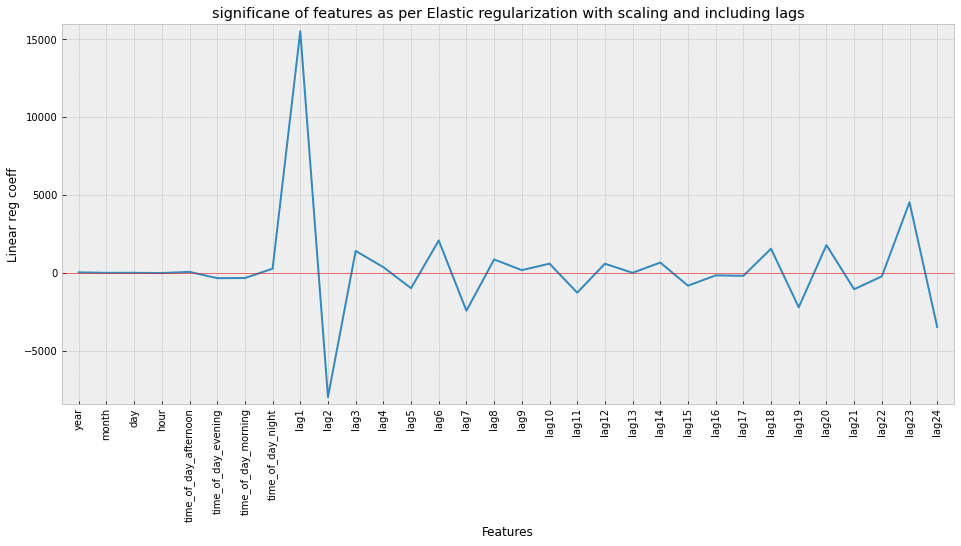

In [169]:
# Plot the coefficients
_ = plt.figure(figsize = (16, 7))
_ = plt.plot(range(len(X_train_lag.columns)), elastic_net_lag.coef_)
_ = plt.xticks(range(len(X_train_lag.columns)), X_train_lag.columns.values, rotation = 90)
_ = plt.margins(0.02)
_ = plt.axhline(0, linewidth = 0.5, color = 'r')
_ = plt.title('significane of features as per Elastic regularization with scaling and including lags')
_ = plt.ylabel('Linear reg coeff')
_ = plt.xlabel('Features')

In [170]:
#rflag = RandomForestRegressor()
#rflag.fit()

# First create the base model to tune
rf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
# Random search of parameters
rflag = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = tscv, verbose=2, random_state = 42, n_jobs = -1)

# Fit the random search model
rflag.fit(X_train_lag, y_train_lag)

rflag.best_params_
#rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.7min finished


{'n_estimators': 73, 'max_features': 'auto', 'max_depth': 5}

In [171]:
# comparison of scores using elastic net and RF on the lag dataset
print('Random forest errors with lags on training')
error_metrics(rflag.predict(X_train_lag), y_train_lag, model_name = 'Random forest with all lags', test=False)
print('\nRandom forest errors with lags on test')
error_metrics(rflag.predict(X_test_lag), y_test_lag, model_name = 'Random forest with all lags', test=True)
print('\nElastic net errors with lags on train')
error_metrics(elastic_net_lag.predict(X_train_lag), y_train_lag, model_name = 'Elastic net with all lags', test=False)
print('\nElastic net errors with lags on test')
error_metrics(elastic_net_lag.predict(X_test_lag), y_test_lag, model_name = 'Elastic net with all lags', test=True)

Random forest errors with lags on training

Error metrics for model Random forest with all lags
RMSE or Root mean squared error: 1706.68
Variance score: 0.97
Mean Absolute Error: 1290.34
Mean Absolute Percentage Error: 2.65 %

Random forest errors with lags on test

Error metrics for model Random forest with all lags
RMSE or Root mean squared error: 1775.62
Variance score: 0.95
Mean Absolute Error: 1362.98
Mean Absolute Percentage Error: 2.78 %

Elastic net errors with lags on train

Error metrics for model Elastic net with all lags
RMSE or Root mean squared error: 1008.20
Variance score: 0.99
Mean Absolute Error: 699.43
Mean Absolute Percentage Error: 1.39 %

Elastic net errors with lags on test

Error metrics for model Elastic net with all lags
RMSE or Root mean squared error: 982.48
Variance score: 0.99
Mean Absolute Error: 706.89
Mean Absolute Percentage Error: 1.40 %


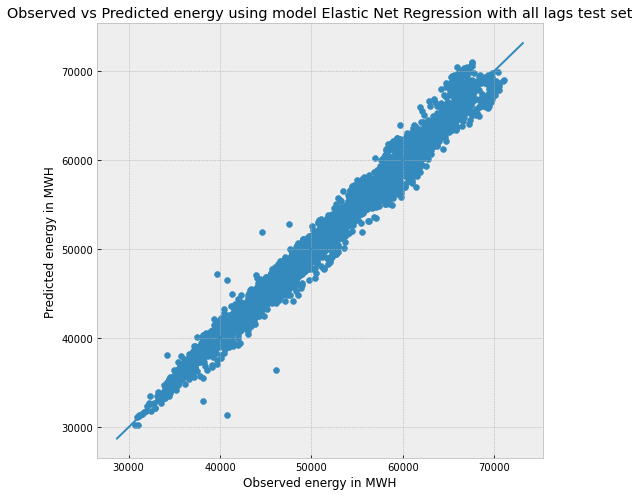

In [172]:
plot_predvstrue_reg(elastic_net_lag.predict(X_test_lag), y_test_lag, 
                    model_name = 'Elastic Net Regression with all lags test set')

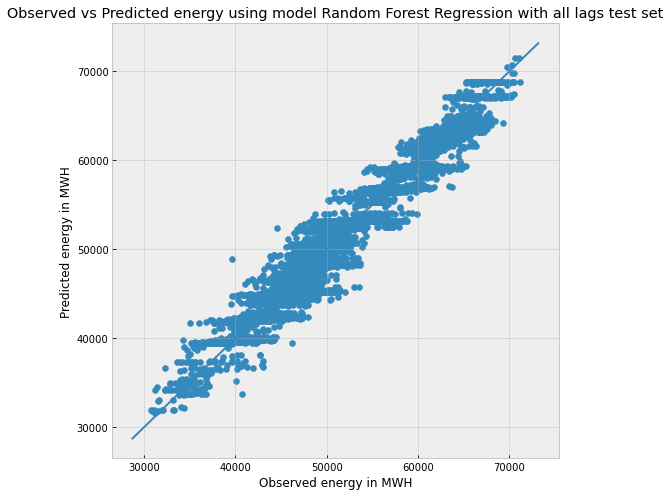

In [173]:
plot_predvstrue_reg(rflag.predict(X_test_lag), y_test_lag, 
                    model_name = 'Random Forest Regression with all lags test set')

In [174]:
# Plotting the observed test values, and predicted test values using the above Elastic net and Random forest models using lags
#..up to last 24 hour values

fig = go.Figure()

fig.add_trace(go.Scatter(x = X_test_lag.index, y = np.array(y_test_lag), name = "observed",
                         line_color = 'deepskyblue', opacity = 0.5))

fig.add_trace(go.Scatter(x = X_test_lag.index, y = rflag.predict(X_test_lag), name = "Random forest predictions",
                         line_color = 'lightslategrey', opacity = 0.5))

fig.add_trace(go.Scatter(x = X_test_lag.index, y = elastic_net_lag.predict(X_test_lag), name = "Elastic net predictions",
                         line_color = 'lightcoral', opacity = 0.5))

fig.update_layout(title_text = 'Observed test set vs Predicted energy using Random forest & elastic net \
reg using lags upto 24h on test set',
                  xaxis_rangeslider_visible = True)
fig.show()

In [175]:
data_

load_nl  year  month  day  hour  \
start                                                        
2015-01-02 00:00:00+00:00  33211.0  2015      1    2     0   
2015-01-02 01:00:00+00:00  31504.0  2015      1    2     1   
2015-01-02 02:00:00+00:00  30801.0  2015      1    2     2   
2015-01-02 03:00:00+00:00  31086.0  2015      1    2     3   
2015-01-02 04:00:00+00:00  33018.0  2015      1    2     4   
...                            ...   ...    ...  ...   ...   
2020-07-31 19:00:00+00:00  51383.0  2020      7   31    19   
2020-07-31 20:00:00+00:00  50887.0  2020      7   31    20   
2020-07-31 21:00:00+00:00  48864.0  2020      7   31    21   
2020-07-31 22:00:00+00:00  46698.0  2020      7   31    22   
2020-07-31 23:00:00+00:00  44571.0  2020      7   31    23   

                           time_of_day_afternoon  time_of_day_evening  \
start                                                                   
2015-01-02 00:00:00+00:00                      0                    0   
2015-01-02 01:00:00+00:00                      0                    0   
2015-01-02 02:00:00+00:00                      0                    0   
2015-01-02 03:00:00+00:00                      0                    0   
2015-01-02 04:00:00+00:00                      0                    0   
...                                          ...                  ...   
2020-07-31 19:00:00+00:00                      0                    1   
2020-07-31 20:00:00+00:00                      0                    1   
2020-07-31 21:00:00+00:00                      0                    1   
2020-07-31 22:00:00+00:00                      0                    0   
2020-07-31 23:00:00+00:00                      0                    0   

                           time_of_day_morning  time_of_day_night     lag1  \
start                                                                        
2015-01-02 00:00:00+00:00                    0                  1  35981.0   
2015-01-02 01:00:00+00:00                    0                  1  33211.0   
2015-01-02 02:00:00+00:00                    0                  1  31504.0   
2015-01-02 03:00:00+00:00                    0                  1  30801.0   
2015-01-02 04:00:00+00:00                    0                  1  31086.0   
...                                        ...                ...      ...   
2020-07-31 19:00:00+00:00                    0                  0  51488.0   
2020-07-31 20:00:00+00:00                    0                  0  51383.0   
2020-07-31 21:00:00+00:00                    0                  0  50887.0   
2020-07-31 22:00:00+00:00                    0                  1  48864.0   
2020-07-31 23:00:00+00:00                    0                  1  46698.0   

                              lag2     lag3     lag4     lag5     lag6  \
start                                                                    
2015-01-02 00:00:00+00:00  39295.0  42254.0  43513.0  45459.0  46866.0   
2015-01-02 01:00:00+00:00  35981.0  39295.0  42254.0  43513.0  45459.0   
2015-01-02 02:00:00+00:00  33211.0  35981.0  39295.0  42254.0  43513.0   
2015-01-02 03:00:00+00:00  31504.0  33211.0  35981.0  39295.0  42254.0   
2015-01-02 04:00:00+00:00  30801.0  31504.0  33211.0  35981.0  39295.0   
...                            ...      ...      ...      ...      ...   
2020-07-31 19:00:00+00:00  50338.0  48501.0  46348.0  43000.0  41110.0   
2020-07-31 20:00:00+00:00  51488.0  50338.0  48501.0  46348.0  43000.0   
2020-07-31 21:00:00+00:00  51383.0  51488.0  50338.0  48501.0  46348.0   
2020-07-31 22:00:00+00:00  50887.0  51383.0  51488.0  50338.0  48501.0   
2020-07-31 23:00:00+00:00  48864.0  50887.0  51383.0  51488.0  50338.0   

                              lag7     lag8     lag9    lag10    lag11  \
start                                                                    
2015-01-02 00:00:00+00:00  49197.0  50732.0  48347.0  47316.0  48270.0   
2015-01-02 01:00:00+00:00  46866.0  49197.0  50732.0  48347.0  47316.0

In [180]:
ts_sdge = pd.DataFrame(data_, columns=['load_nl'])

In [181]:
ts_sdge

load_nl
start                             
2015-01-02 00:00:00+00:00  33211.0
2015-01-02 01:00:00+00:00  31504.0
2015-01-02 02:00:00+00:00  30801.0
2015-01-02 03:00:00+00:00  31086.0
2015-01-02 04:00:00+00:00  33018.0
...                            ...
2020-07-31 19:00:00+00:00  51383.0
2020-07-31 20:00:00+00:00  50887.0
2020-07-31 21:00:00+00:00  48864.0
2020-07-31 22:00:00+00:00  46698.0
2020-07-31 23:00:00+00:00  44571.0

[48912 rows x 1 columns]

In [183]:
plot_timeseries(ts_sdge['load_nl'], title = 'Original data set')

start
2015-01-02 00:00:00+00:00    -8238.436067
2015-01-02 01:00:00+00:00    -9522.309766
2015-01-02 02:00:00+00:00   -10625.987791
2015-01-02 03:00:00+00:00   -11389.097882
2015-01-02 04:00:00+00:00   -11186.655530
Freq: H, Name: seasonal, dtype: float64


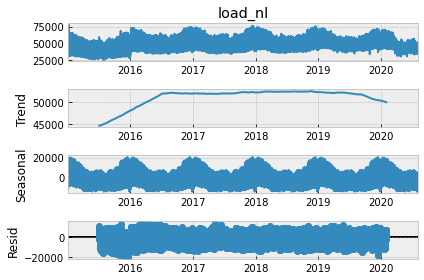

In [184]:
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
decomp = sm.tsa.seasonal_decompose(ts_sdge['load_nl'], freq=24*365) # capturing the yearly seasonal component; i.e. for example 
#... every July the energy consumption is high and then it gets lower during the winter months. 
#...So, a periodicity of 24hours*365 was used here.

print(decomp.seasonal.head()) # checking the seasonal component
_ = decomp.plot()

our data has a periodicity of 24*365 hours.
The trend shows how the energy consumption decreases over the years from 2014-18 which we had already inferred from the linear regression coefficient values for the year variable from the linear regression models. But, another important thing to keep in mind here is that the trend, though observably clear, is very small.
The seasonal component captures the summer and winter trends very well too.

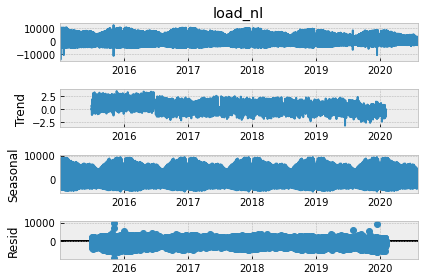

In [185]:
decomp_diff1 = sm.tsa.seasonal_decompose(ts_sdge['load_nl'].diff().dropna(), freq=24*365) 
_ = decomp_diff1.plot()

In [188]:
from statsmodels.tsa.stattools import adfuller
def run_adfuller(ts):
    result = adfuller(ts)
    # Print test statistic
    print("t-stat", result[0])
    # Print p-value
    print("p-value", result[1])
    # Print #lags used
    print("#lags used", result[2])
    # Print critical values
    print("critical values", result[4]) 
print("for no differencing\n")
run_adfuller(ts_sdge['load_nl'])
print("\nfor single differencing\n")
run_adfuller(ts_sdge['load_nl'].diff().dropna())
print("\nfor differenced data set over lags 24 after single differencing\n")
run_adfuller(ts_sdge['load_nl'].diff().dropna().diff(24).dropna())    

for no differencing

t-stat -15.51394488622309
p-value 2.329321754051726e-28
#lags used 57
critical values {'1%': -3.430483860965908, '5%': -2.861599163767208, '10%': -2.5668014909218866}

for single differencing

t-stat -39.22167360849808
p-value 0.0
#lags used 56
critical values {'1%': -3.430483860965908, '5%': -2.861599163767208, '10%': -2.5668014909218866}

for differenced data set over lags 24 after single differencing

t-stat -47.547854658321256
p-value 0.0
#lags used 57
critical values {'1%': -3.430483929505098, '5%': -2.861599194059423, '10%': -2.5668015070455525}


In [189]:
#The seasonal period of 24 hours can be easily observed from the plots above.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def acf_pacf_plots(ts, lags, figsize = (12,8)):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = figsize)
    
    # Plot the ACF of ts
    _ = plot_acf(ts, lags = lags, zero = False, ax = ax1, alpha = 0.05)

    # Plot the PACF of ts
    _ = plot_pacf(ts, lags = lags, zero = False, ax = ax2, alpha = 0.05)


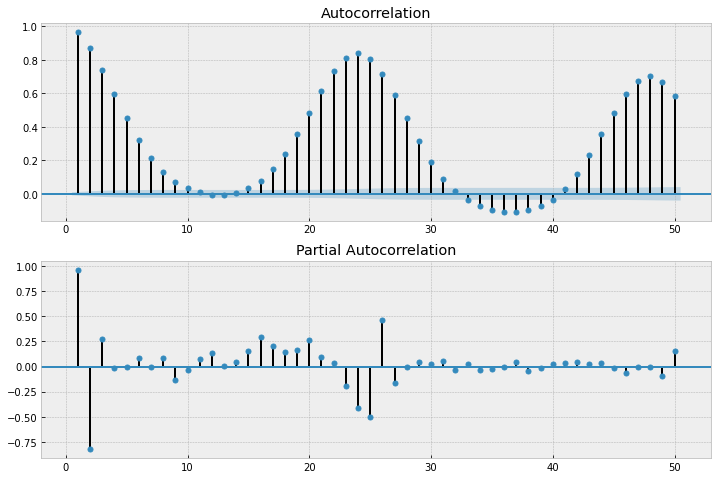

In [190]:
dfacf = []
dfacf = ts_sdge['load_nl']
lags = 50

acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

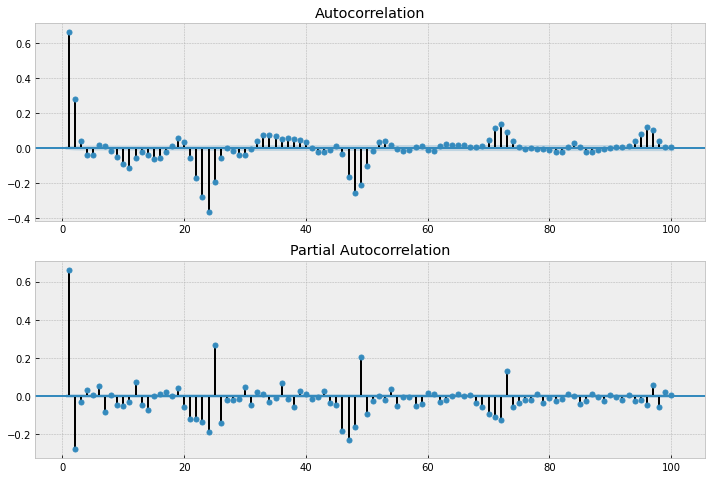

In [191]:
# Differencing the data this time to remove the trend and seasonality
dfacf = []
dfacf = ts_sdge['load_nl']
dfacf = dfacf.diff().dropna() 
dfacf = dfacf.diff(24).dropna()
dfacf = dfacf.diff(24*365).dropna()
lags = 100

acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

This is a common pitfall of the ACF, PACF plots and SARIMAX models. They cannot handle multiple seasonality. And our energy consumption dataset has multiple seasonalities - daily (24 hours), weekly (168hours), yearly (24*365.25). We'll have to deal with the multiple seasonality separately to be able to use SARIMAX model on our energy consumption time series

In [230]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

# We can add multiple fourer series with different k terms in the (2*k*pi) such as k=1,2,3...etc. To generalize the problem, 
# we could have chosen an optimal k value for each season by trying out some k values and choosing the values giving 
#the lowest AIC.

def add_fourier_terms(df, year_k, week_k, day_k):
    """
    df: dataframe to add the fourier terms to 
    year_k: the number of Fourier terms the year period should have. Thus the model will be fit on 2*year_k terms (1 term for 
    sine and 1 for cosine)
    week_k: same as year_k but for weekly periods
    day_k:same as year_k but for daily periods
    """
    
    for k in range(1, year_k+1):
        # year has a period of 365.25 including the leap year
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25) 
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)

    for k in range(1, week_k+1):
        
        # week has a period of 7
        df['week_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofweek/7)
        df['week_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofweek/7)


    for k in range(1, day_k+1):
        
        # day has period of 24
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24)
warnings.filterwarnings('ignore')

# as said above the k terms for each yearly, weekly and daily seasonalities could be chosen by optimizing on the AIC values..
# but after some research on energy consumption time series k= 5 was chosen for each seasonality
add_fourier_terms(lag_sdge, year_k= 5, week_k=5 , day_k=5)        

In [231]:
lag_sdge.columns

Index(['load_nl', 'year', 'month', 'day', 'hour', 'time_of_day_afternoon',
       'time_of_day_evening', 'time_of_day_morning', 'time_of_day_night',
       'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9',
       'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17',
       'lag18', 'lag19', 'lag20', 'lag21', 'lag22', 'lag23', 'lag24',
       'year_sin1', 'year_cos1', 'year_sin2', 'year_cos2', 'year_sin3',
       'year_cos3', 'year_sin4', 'year_cos4', 'year_sin5', 'year_cos5',
       'week_sin1', 'week_cos1', 'week_sin2', 'week_cos2', 'week_sin3',
       'week_cos3', 'week_sin4', 'week_cos4', 'week_sin5', 'week_cos5',
       'hour_sin1', 'hour_cos1', 'hour_sin2', 'hour_cos2', 'hour_sin3',
       'hour_cos3', 'hour_sin4', 'hour_cos4', 'hour_sin5', 'hour_cos5'],
      dtype='object')

In [206]:
sdgecyc = lag_sdge.drop([col for col in lag_sdge if 
                         col.startswith('time') or col.startswith('season') or col.startswith('lag')], axis=1)
sdgecyc.head()

load_nl  year  month  day  hour  year_sin1  \
start                                                                   
2015-01-02 00:00:00+00:00  33211.0  2015      1    2     0   0.034398   
2015-01-02 01:00:00+00:00  31504.0  2015      1    2     1   0.034398   
2015-01-02 02:00:00+00:00  30801.0  2015      1    2     2   0.034398   
2015-01-02 03:00:00+00:00  31086.0  2015      1    2     3   0.034398   
2015-01-02 04:00:00+00:00  33018.0  2015      1    2     4   0.034398   

                           year_cos1  year_sin2  year_cos2  year_sin3  \
start                                                                   
2015-01-02 00:00:00+00:00   0.999408   0.068755   0.997634   0.103031   
2015-01-02 01:00:00+00:00   0.999408   0.068755   0.997634   0.103031   
2015-01-02 02:00:00+00:00   0.999408   0.068755   0.997634   0.103031   
2015-01-02 03:00:00+00:00   0.999408   0.068755   0.997634   0.103031   
2015-01-02 04:00:00+00:00   0.999408   0.068755   0.997634   0.103031   

                           year_cos3  year_sin4  year_cos4  year_sin5  \
start                                                                   
2015-01-02 00:00:00+00:00   0.994678   0.137185   0.990545   0.171177   
2015-01-02 01:00:00+00:00   0.994678   0.137185   0.990545   0.171177   
2015-01-02 02:00:00+00:00   0.994678   0.137185   0.990545   0.171177   
2015-01-02 03:00:00+00:00   0.994678   0.137185   0.990545   0.171177   
2015-01-02 04:00:00+00:00   0.994678   0.137185   0.990545   0.171177   

                           year_cos5  week_sin1  week_cos1  week_sin2  \
start                                                                   
2015-01-02 00:00:00+00:00    0.98524  -0.433884  -0.900969   0.781831   
2015-01-02 01:00:00+00:00    0.98524  -0.433884  -0.900969   0.781831   
2015-01-02 02:00:00+00:00    0.98524  -0.433884  -0.900969   0.781831   
2015-01-02 03:00:00+00:00    0.98524  -0.433884  -0.900969   0.781831   
2015-01-02 04:00:00+00:00    0.98524  -0.433884  -0.900969   0.781831   

                           week_cos2  week_sin3  week_cos3  week_sin4  \
start                                                                   
2015-01-02 00:00:00+00:00    0.62349  -0.974928  -0.222521   0.974928   
2015-01-02 01:00:00+00:00    0.62349  -0.974928  -0.222521   0.974928   
2015-01-02 02:00:00+00:00    0.62349  -0.974928  -0.222521   0.974928   
2015-01-02 03:00:00+00:00    0.62349  -0.974928  -0.222521   0.974928   
2015-01-02 04:00:00+00:00    0.62349  -0.974928  -0.222521   0.974928   

                           week_cos4  week_sin5  week_cos5  hour_sin1  \
start                                                                   
2015-01-02 00:00:00+00:00  -0.222521  -0.781831    0.62349   0.000000   
2015-01-02 01:00:00+00:00  -0.222521  -0.781831    0.62349   0.258819   
2015-01-02 02:00:00+00:00  -0.222521  -0.781831    0.62349   0.500000   
2015-01-02 03:00:00+00:00  -0.222521  -0.781831    0.62349   0.707107   
2015-01-02 04:00:00+00:00  -0.222521  -0.781831    0.62349   0.866025   

                           hour_cos1  hour_sin2     hour_cos2     hour_sin3  \
start                                                                         
2015-01-02 00:00:00+00:00   1.000000   0.000000  1.000000e+00  0.000000e+00   
2015-01-02 01:00:00+00:00   0.965926   0.500000  8.660254e-01  7.071068e-01   
2015-01-02 02:00:00+00:00   0.866025   0.866025  5.000000e-01  1.000000e+00   
2015-01-02 03:00:00+00:00   0.707107   1.000000  6.123234e-17  7.071068e-01   
2015-01-02 04:00:00+00:00   0.500000   0.866025 -5.000000e-01  1.224647e-16   

                              hour_cos3     hour_sin4  hour_cos4  hour_sin5  \
start                                                                         
2015-01-02 00:00:00+00:00  1.000000e+00  0.000000e+00        1.0   0.000000   
2015-01-02 01:00:00+00:00  7.071068e-01  8.660254e-01        0.5   0.965926   
2015-01-02 02:00:00+00:00  6.123234e-17  8.660254e-01       -0.5   0.500000   
2015-0

In [207]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
# Choosing a subset of the above dataframe; removing the lags and the hour bins


X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test(sdgecyc, 
                                                              test_size = 0.15, scale = True, 
                                                              cols_to_transform=['year'],include_test_scale=False,z='load_nl')
# Since ARIMA model uses the past lag y values, scaling the energy values as well. 
#i.e. fit the scaler on y_train and transform it and also transform y_test using the same scaler if required later

scaler1 = StandardScaler()
y_train_lag = pd.DataFrame(scaler1.fit_transform(y_train_lag.values.reshape(-1,1)), index = y_train_lag.index, 
                           columns = ['load_nl'])
# y_test_lag = scaler1.transform(y_test_lag)

In [208]:
model_opt = SARIMAX(y_train_lag, order=(2,1,1), seasonal_order=(1, 0, 1, 24), exog = X_train_lag, trend='c')

In [210]:
results = model_opt.fit()

In [211]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            load_nl   No. Observations:                41575
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 24)   Log Likelihood               46045.363
Date:                            Sat, 26 Dec 2020   AIC                         -92008.726
Time:                                    22:12:04   BIC                         -91654.682
Sample:                                01-02-2015   HQIC                        -91896.864
                                     - 09-30-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.213e-05      0.000      0.600      0.548      -0.000       0.000
year          -0.1389     15.002     -0.009      0.993     -29.542      29.264
month         -0.0035      0.910     -0.004      0.997      -1.787       1.780
day           -0.0002      0.030     -0.008      0.994      -0.059       0.059
hour           0.0003      0.002      0.148      0.882      -0.004       0.004
year_sin1     -3.4552      2.471     -1.398      0.162      -8.299       1.388
year_cos1      0.6565      2.761      0.238      0.812      -4.756       6.069
year_sin2     -0.7452      1.127     -0.661      0.508      -2.954       1.464
year_cos2      0.0515      1.159      0.044      0.965      -2.221       2.324
year_sin3      0.1859      0.628      0.296      0.767      -1.046       1.418
year_cos3     -0.2051      0.588     -0.349      0.727      -1.357       0.947
year_sin4      0.0931      0.365      0.255      0.799      -0.622       0.808
year_cos4     -0.1222      0.384     -0.318      0.750      -0.875       0.630
year_sin5     -0.0150      0.231     -0.065      0.948      -0.467       0.437
year_cos5      0.0181      0.237      0.076      0.939      -0.447       0.483
week_sin1      0.0145      0.005      2.692      0.007       0.004       0.025
week_cos1     -0.0069      0.005     -1.445      0.148      -0.016       0.002
week_sin2     -0.0071      0.004     -1.792      0.073      -0.015       0.001
week_cos2     -0.0007      0.001     -0.504      0.615      -0.003       0.002
week_sin3     -0.0161      0.004     -4.086      0.000      -0.024      -0.008
week_cos3      0.0004      0.001      0.411      0.681      -0.001       0.002
week_sin4     -0.0170      0.004     -4.323      0.000      -0.025      -0.009
week_cos4      0.0004      0.001      0.411      0.681      -0.001       0.002
week_sin5     -0.0079      0.004     -1.968      0.049      -0.016   -3.04e-05
week_cos5     -0.0007      0.001     -0.504      0.615      -0.003       0.002
hour_sin1     -0.2789      0.075     -3.726      0.000      -0.426      -0.132
hour_cos1     -0.8699      0.058    -14.963      0.000      -0.984      -0.756
hour_sin2     -0.2345      0.023    -10.224      0.000      -0.279      -0.190
hour_cos2     -0.3477      0.030    -11.707      0.000      -0.406      -0.290
hour_sin3     -0.0219      0.012     -1.804      0.071      -0.046       0.002
hour_cos3      0.0885      0.015      5.883      0.000       0.059       0.118
hour_sin4      0.0329      0.007      4.501      0.000       0.019       0.047
hour_cos4      0.0380      0.008      4.897      0.000       0.023       0.053
hour_sin5      0.0749      0.005     15.635      0.000       0.066       0.084
hour_cos5      0.0087      0.005      1.845      0.065      -0.001       0.018
ar.L1          0.8939      0.020     44.535      0.000       0.855       0.933
ar.L2         -0.2102      0.015    -13.565      0.0

In [212]:
# Predictions on train set. Predicting only the last week of the training set

# Setting dynamic = True so that the model won't use actual enegy values for prediction. Basically the model will use
# the lag terms and moving average terms of the already forecasted energy values. So, we will see the errors 
#(confidence interval) increasing with each forecast.
pred = results.get_prediction(start=X_train_lag.index[-24*7], end=X_train_lag.index[-1], 
                              dynamic=True, exog=X_train_lag.iloc[-24*7:, :])
pred_ci = pred.conf_int()

pred1 = scaler1.inverse_transform(pred.predicted_mean)
pred_ci1 = scaler1.inverse_transform(pred.conf_int())

y_actual_train = np.squeeze(scaler1.inverse_transform(y_train_lag))
y_actual_train = pd.Series(y_actual_train, index = X_train_lag.index )

pred1 = pd.Series(pred1, index = X_train_lag.iloc[-24*7:, :].index )
pred_ci1 = pd.DataFrame(pred_ci1, index = pred1.index, columns = ['lower SDGE', 'upper SDGE'])

lower_limits = pred_ci1.loc[:,'lower SDGE']
upper_limits = pred_ci1.loc[:,'upper SDGE']

In [213]:
error_metrics(pred1, y_actual_train.iloc[-24*7:], 'SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week', 
              test=False)


Error metrics for model SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week
RMSE or Root mean squared error: 19551.68
Variance score: -7.56
Mean Absolute Error: 17141.77
Mean Absolute Percentage Error: 35.15 %


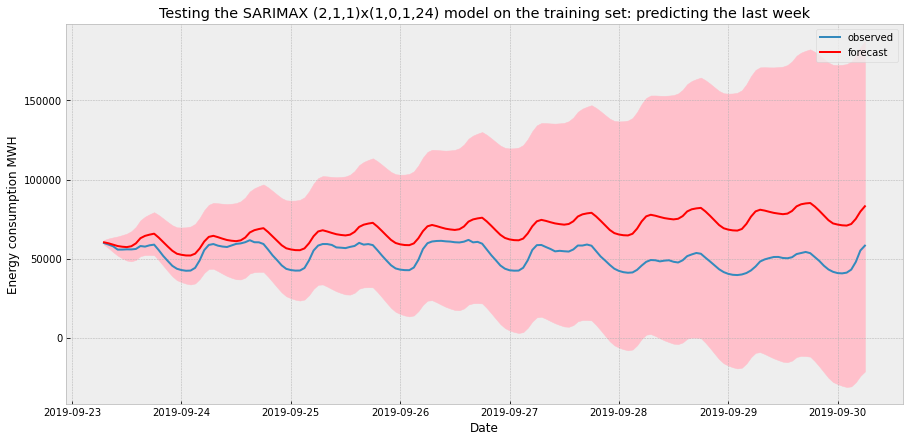

In [214]:
#plot_ts_pred(y_actual_train.iloc[-24*7:], pred1 , model_name='SARIMA (0,1,2)x(1,0,1,24)', 
#             og_ts_opacity = 0.5, pred_ts_opacity = 0.5)
# plot the predictions
plt.figure(figsize = (15,7))
_ = plt.plot(y_actual_train.iloc[-24*7:].index, y_actual_train.iloc[-24*7:], label='observed')

# plot your mean predictions
_ = plt.plot(pred1.index, pred1.values, color='r', label='forecast')

# shade the area between your confidence limits
_ = plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy consumption MWH')
_ = plt.legend()
_ = plt.title('Testing the SARIMAX (2,1,1)x(1,0,1,24) model on the training set: predicting the last week')

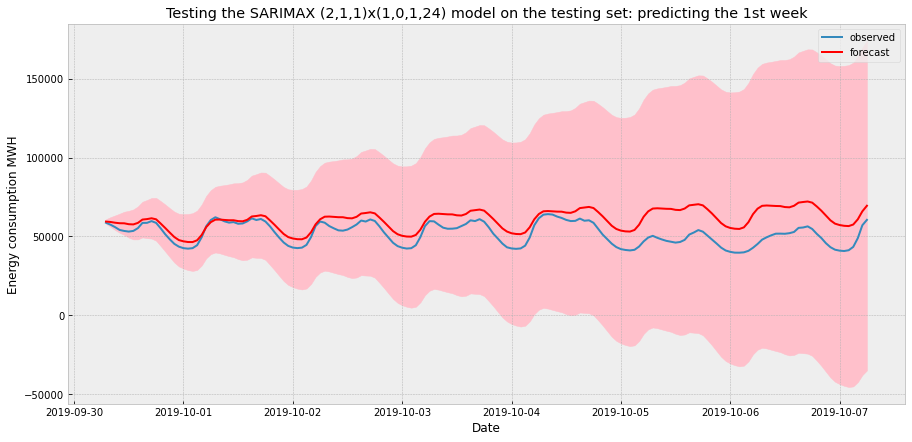

In [215]:
# Predictions on test set. Predicting only the 1st week of the test set
pred = results.get_forecast(steps = 24*7, exog = X_test_lag.iloc[:24*7, :])
pred_ci = pred.conf_int()

pred2 = scaler1.inverse_transform(pred.predicted_mean)
pred_ci2 = scaler1.inverse_transform(pred.conf_int())

y_actual = y_test_lag.iloc[:24*7]

pred2 = pd.Series(pred2, index = X_test_lag.iloc[:24*7, :].index )
pred_ci2 = pd.DataFrame(pred_ci2, index = pred2.index, columns = ['lower SDGE', 'upper SDGE'])

lower_limits = pred_ci2.loc[:,'lower SDGE']
upper_limits = pred_ci2.loc[:,'upper SDGE']

# plot the predictions
plt.figure(figsize = (15,7))
_ = plt.plot(y_actual.index, y_actual, label='observed')

# plot your mean predictions
_ = plt.plot(pred2.index, pred2.values, color='r', label='forecast')

# shade the area between your confidence limits
_ = plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy consumption MWH')
_ = plt.legend()
_ = plt.title('Testing the SARIMAX (2,1,1)x(1,0,1,24) model on the testing set: predicting the 1st week')

In [216]:
error_metrics(pred2, y_actual, 'SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week', test=True) 


Error metrics for model SARIMAX(2,1,1)x(1,0,1,24) with Fourier terms 1 week
RMSE or Root mean squared error: 10783.27
Variance score: -1.43
Mean Absolute Error: 8927.09
Mean Absolute Percentage Error: 18.38 %


We see that the first week forecast is pretty well but even at the end of first week the forecasting performance decreases and the confidence interval values grow larger beyond the scale of the range of the energy consumption values. Thus, SARIMAX model was not able to capture long term trends but it did well on 1 week ahead forecast.
SARIMA models don't capture multiple seasonalities well and are also very time consuming. So, it won't be the first choice if we need both a quick and accurate forecast.
Errors for 1 hour ahead forecasts weren't calculated above for SARIMAX model (by usign dynamic=True) because we get excellent results using elastic net regression for 1 hour ahead forecasts using the lag variables and it is much faster to fit than SARIMAX. So, if 1 hour ahead forecasting is the goal then elastic net regression should be used.

Face Book Prophet 

In [217]:
X_trainP, X_testP, y_trainP, y_testP = train_test\
                           (lag_sdge[['load_nl']], 
                           test_size=0.15, 
                           scale=False, #True
                           #cols_to_transform=cols_to_transform,
                           include_test_scale=False,z='load_nl')

In [218]:
# preparing data for Prophet
def data_prophet(X_train, X_test, y_train, y_test):
    data_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
    data_train = data_train.reset_index().rename(columns = {'SDGE':'y', 'Dates':'ds'})
    data_test = pd.merge(X_test, y_test, left_index=True, right_index=True)
    data_test  = data_test.reset_index().rename(columns = {'SDGE':'y', 'Dates':'ds'})
    return data_train, data_test

In [219]:
data_train, data_test = data_prophet(X_trainP, X_testP, y_trainP, y_testP)

In [220]:
data_train.tail(3)

start  load_nl
41572 2019-09-30 04:00:00+00:00  47908.0
41573 2019-09-30 05:00:00+00:00  55129.0
41574 2019-09-30 06:00:00+00:00  58232.0